# Descrição

O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

### Imports

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import optuna
import warnings

warnings.filterwarnings('ignore')

## Preparação de Dados

In [2]:
df = pd.read_csv('car_data.csv')

In [3]:
df

,Unnamed: 0,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         354369 non-null  int64 
 1   DateCrawled        354369 non-null  object
 2   Price              354369 non-null  int64 
 3   VehicleType        316879 non-null  object
 4   RegistrationYear   354369 non-null  int64 
 5   Gearbox            334536 non-null  object
 6   Power              354369 non-null  int64 
 7   Model              334664 non-null  object
 8   Mileage            354369 non-null  int64 
 9   RegistrationMonth  354369 non-null  int64 
 10  FuelType           321474 non-null  object
 11  Brand              354369 non-null  object
 12  NotRepaired        283215 non-null  object
 13  DateCreated        354369 non-null  object
 14  NumberOfPictures   354369 non-null  int64 
 15  PostalCode         354369 non-null  int64 
 16  LastSeen           3

Dados ausentes em VehicleType, Gearbox, Model, FuelType, NotRepaired

## Pré-processamento de dados

In [5]:
colunas_essenciais = ['Price', 'VehicleType', 'RegistrationYear','Gearbox', 'Power', 'Mileage', 'FuelType', 'Brand','NotRepaired', 'Model']
df_new = df[colunas_essenciais]

df_new

,Price,VehicleType,RegistrationYear,Gearbox,Power,Mileage,FuelType,Brand,NotRepaired,Model
0,480,NaN,1993,manual,0,150000,petrol,volkswagen,NaN,golf
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes,NaN
2,9800,suv,2004,auto,163,125000,gasoline,jeep,NaN,grand
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no,golf
4,3600,small,2008,manual,69,90000,gasoline,skoda,no,fabia
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,150000,petrol,mitsubishi,yes,colt
354365,2200,NaN,2005,NaN,0,20000,NaN,sonstige_autos,NaN,NaN
354366,1199,convertible,2000,auto,101,125000,petrol,smart,no,fortwo
354367,9200,bus,1996,manual,102,150000,gasoline,volkswagen,no,transporter


In [6]:
df_new.columns = [coluna.lower() for coluna in df_new.columns]

df_new

,price,vehicletype,registrationyear,gearbox,power,mileage,fueltype,brand,notrepaired,model
0,480,NaN,1993,manual,0,150000,petrol,volkswagen,NaN,golf
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes,NaN
2,9800,suv,2004,auto,163,125000,gasoline,jeep,NaN,grand
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no,golf
4,3600,small,2008,manual,69,90000,gasoline,skoda,no,fabia
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,150000,petrol,mitsubishi,yes,colt
354365,2200,NaN,2005,NaN,0,20000,NaN,sonstige_autos,NaN,NaN
354366,1199,convertible,2000,auto,101,125000,petrol,smart,no,fortwo
354367,9200,bus,1996,manual,102,150000,gasoline,volkswagen,no,transporter


Decidi remover algumas colunas que considerei não ter impacto na previsão dos modelos de ML

### Price

In [7]:
df_new

,price,vehicletype,registrationyear,gearbox,power,mileage,fueltype,brand,notrepaired,model
0,480,NaN,1993,manual,0,150000,petrol,volkswagen,NaN,golf
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes,NaN
2,9800,suv,2004,auto,163,125000,gasoline,jeep,NaN,grand
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no,golf
4,3600,small,2008,manual,69,90000,gasoline,skoda,no,fabia
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,150000,petrol,mitsubishi,yes,colt
354365,2200,NaN,2005,NaN,0,20000,NaN,sonstige_autos,NaN,NaN
354366,1199,convertible,2000,auto,101,125000,petrol,smart,no,fortwo
354367,9200,bus,1996,manual,102,150000,gasoline,volkswagen,no,transporter


In [8]:
Q1 = df_new['price'].quantile(0.25)
Q3 = df_new['price'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = df_new[(df_new['price'] < lower_limit) | (df_new['price'] > upper_limit)]
outliers_count = len(outliers)

print(f'Número de outliers em "Price": {outliers_count}')
print('Valores Outliers:')
print(outliers[['price']])

Número de outliers em "Price": 18979
Valores Outliers:
        price
1       18300
8       14500
14      17999
33      18000
50      14800
...       ...
354259  15000
354279  16500
354286  16500
354306  16999
354319  19800

[18979 rows x 1 columns]


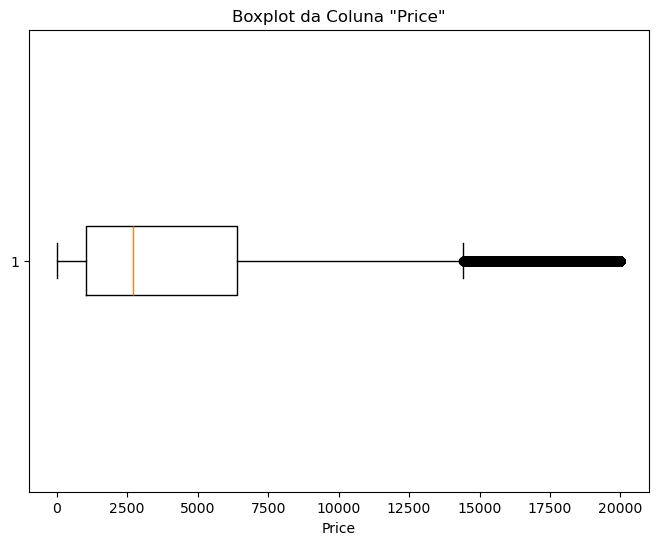

In [9]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_new['price'], vert=False)
plt.title('Boxplot da Coluna "Price"')
plt.xlabel('Price')
plt.show()

Apesar da grande presença de outliers nessa coluna, acredito que não seja um problema, uma vez que se trata de preços de carros muito distintos e com características diferentes. A presença de carros com valores muito altos em relação à mediana parece ser normal.

### VehicleType

In [10]:
df_new.dropna(subset=['vehicletype'], inplace=True)

df_new.reset_index(drop=True, inplace=True)

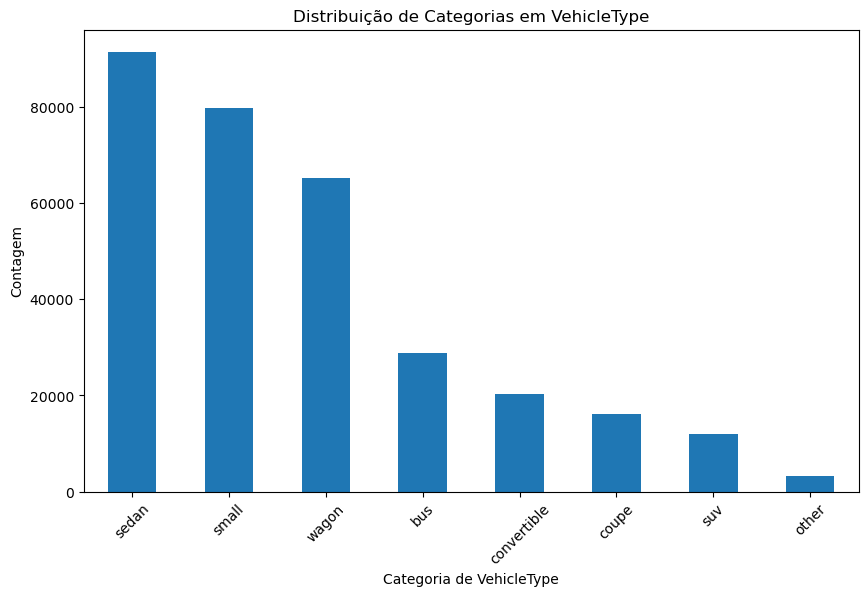

In [11]:
vehicle_type_counts = df_new['vehicletype'].value_counts()

plt.figure(figsize=(10, 6))
vehicle_type_counts.plot(kind='bar')
plt.title('Distribuição de Categorias em VehicleType')
plt.xlabel('Categoria de VehicleType')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

In [12]:
grouped = df_new.groupby('vehicletype')

outliers_by_category = {}

for category, group_data in grouped:
    
    Q1 = group_data['price'].quantile(0.25)
    Q3 = group_data['price'].quantile(0.75)
    IQR = Q3 - Q1

    
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    
    outliers = group_data[(group_data['price'] < lower_limit) | (group_data['price'] > upper_limit)]
    outliers_count = len(outliers)

    
    outliers_by_category[category] = {
        'outliers_count': outliers_count,
        'outliers_data': outliers[['price']]
    }

for category, results in outliers_by_category.items():
    print(f'Categoria: {category}')
    print(f'Número de outliers: {results["outliers_count"]}')
    print('Valores Outliers:')
    print(results['outliers_data'])
    print('-' * 50)

Categoria: bus
Número de outliers: 1202
Valores Outliers:
        price
292     18880
417     16500
421     19900
669     15900
750     16500
...       ...
315071  17650
315613  17300
315809  19500
316376  16500
316732  17990

[1202 rows x 1 columns]
--------------------------------------------------
Categoria: convertible
Número de outliers: 0
Valores Outliers:
Empty DataFrame
Columns: [price]
Index: []
--------------------------------------------------
Categoria: coupe
Número de outliers: 0
Valores Outliers:
Empty DataFrame
Columns: [price]
Index: []
--------------------------------------------------
Categoria: other
Número de outliers: 238
Valores Outliers:
        price
31      11900
359     13950
1224    12500
1517    16900
1835    11500
...       ...
309155  14999
309651  10950
313456  16999
313919  13999
314021  10999

[238 rows x 1 columns]
--------------------------------------------------
Categoria: sedan
Número de outliers: 3884
Valores Outliers:
        price
28      18000


In [13]:
df_encoded = pd.get_dummies(df_new, columns=['vehicletype'], prefix=['vehicletype'])

df_encoded

,price,registrationyear,gearbox,power,mileage,fueltype,brand,notrepaired,model,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon
0,18300,2011,manual,190,125000,gasoline,audi,yes,NaN,False,False,True,False,False,False,False,False
1,9800,2004,auto,163,125000,gasoline,jeep,NaN,grand,False,False,False,False,False,False,True,False
2,1500,2001,manual,75,150000,petrol,volkswagen,no,golf,False,False,False,False,False,True,False,False
3,3600,2008,manual,69,90000,gasoline,skoda,no,fabia,False,False,False,False,False,True,False,False
4,650,1995,manual,102,150000,petrol,bmw,yes,3er,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316874,3200,2004,manual,225,150000,petrol,seat,yes,leon,False,False,False,False,True,False,False,False
316875,1150,2000,manual,0,150000,petrol,opel,no,zafira,True,False,False,False,False,False,False,False
316876,1199,2000,auto,101,125000,petrol,smart,no,fortwo,False,True,False,False,False,False,False,False
316877,9200,1996,manual,102,150000,gasoline,volkswagen,no,transporter,True,False,False,False,False,False,False,False


In [14]:
# Calculando a correlação entre as colunas binárias 'VehicleType_X' e 'Price'
correlation_matrix = df_encoded[['vehicletype_bus', 'vehicletype_convertible', 'vehicletype_coupe', 'vehicletype_other', 'vehicletype_sedan', 'vehicletype_small','vehicletype_suv', 'vehicletype_wagon' ]].corrwith(df_new['price'])

print(correlation_matrix)

vehicletype_bus            0.057144
vehicletype_convertible    0.122321
vehicletype_coupe          0.068410
vehicletype_other         -0.024443
vehicletype_sedan          0.008963
vehicletype_small         -0.250709
vehicletype_suv            0.188266
vehicletype_wagon          0.024661
dtype: float64


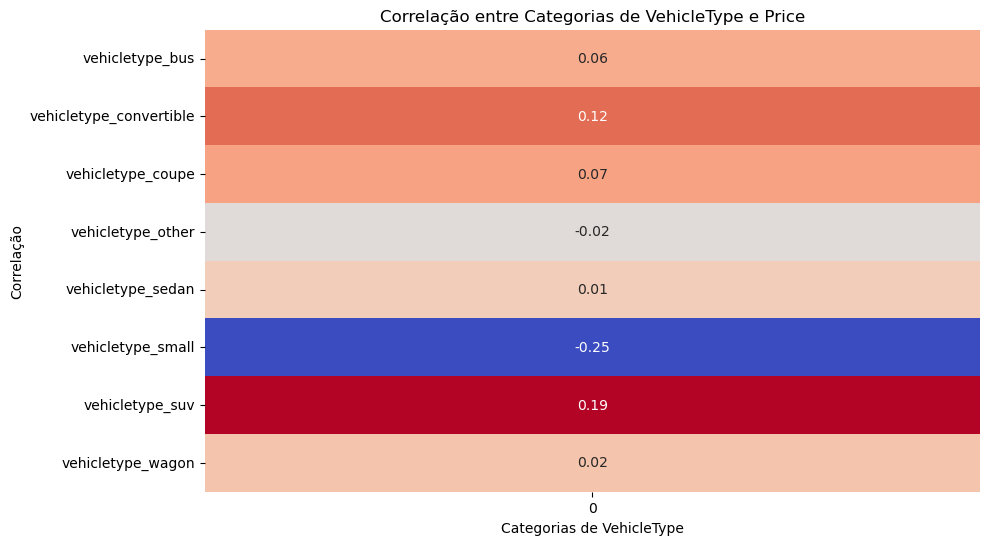

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.to_frame(), cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
plt.title('Correlação entre Categorias de VehicleType e Price')
plt.xlabel('Categorias de VehicleType')
plt.ylabel('Correlação')
plt.show()

### GearBox

In [16]:
df_encoded = df_encoded.dropna(subset=['gearbox'])

In [17]:
temp_encoded = pd.get_dummies(df_new['gearbox'], prefix='gearbox')
df_encoded['gearbox_auto'] = temp_encoded['gearbox_auto']
df_encoded['gearbox_manual'] = temp_encoded['gearbox_manual']

print(df_encoded.head())

   price  registrationyear gearbox  power  mileage  fueltype       brand  \
0  18300              2011  manual    190   125000  gasoline        audi   
1   9800              2004    auto    163   125000  gasoline        jeep   
2   1500              2001  manual     75   150000    petrol  volkswagen   
3   3600              2008  manual     69    90000  gasoline       skoda   
4    650              1995  manual    102   150000    petrol         bmw   

  notrepaired  model  vehicletype_bus  vehicletype_convertible  \
0         yes    NaN            False                    False   
1         NaN  grand            False                    False   
2          no   golf            False                    False   
3          no  fabia            False                    False   
4         yes    3er            False                    False   

   vehicletype_coupe  vehicletype_other  vehicletype_sedan  vehicletype_small  \
0               True              False              False       

In [18]:
df_encoded = df_encoded.drop(columns=['gearbox'])

In [19]:
correlation_matrix = df_encoded.filter(like='gearbox_').corrwith(df_encoded['price'])

print(correlation_matrix)

gearbox_auto      0.250955
gearbox_manual   -0.250955
dtype: float64


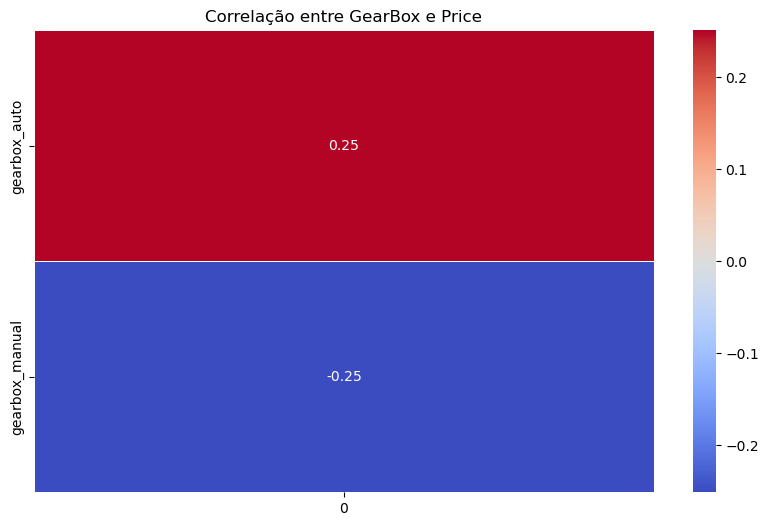

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlação entre GearBox e Price')
plt.show()

### NotRepaired

In [21]:
df_encoded = df_encoded.dropna(subset=['notrepaired'])

In [22]:
temp_encoded = pd.get_dummies(df_new['notrepaired'], prefix='notrepaired')
df_encoded['notrepaired_no'] = temp_encoded['notrepaired_no']
df_encoded['notrepaired_yes'] = temp_encoded['notrepaired_yes']

print(df_encoded.head())

   price  registrationyear  power  mileage  fueltype       brand notrepaired  \
0  18300              2011    190   125000  gasoline        audi         yes   
2   1500              2001     75   150000    petrol  volkswagen          no   
3   3600              2008     69    90000  gasoline       skoda          no   
4    650              1995    102   150000    petrol         bmw         yes   
5   2200              2004    109   150000    petrol     peugeot          no   

     model  vehicletype_bus  vehicletype_convertible  vehicletype_coupe  \
0      NaN            False                    False               True   
2     golf            False                    False              False   
3    fabia            False                    False              False   
4      3er            False                    False              False   
5  2_reihe            False                     True              False   

   vehicletype_other  vehicletype_sedan  vehicletype_small  vehiclet

In [23]:
df_encoded = df_encoded.drop(columns=['notrepaired'])

print(df_encoded.head())

   price  registrationyear  power  mileage  fueltype       brand    model  \
0  18300              2011    190   125000  gasoline        audi      NaN   
2   1500              2001     75   150000    petrol  volkswagen     golf   
3   3600              2008     69    90000  gasoline       skoda    fabia   
4    650              1995    102   150000    petrol         bmw      3er   
5   2200              2004    109   150000    petrol     peugeot  2_reihe   

   vehicletype_bus  vehicletype_convertible  vehicletype_coupe  \
0            False                    False               True   
2            False                    False              False   
3            False                    False              False   
4            False                    False              False   
5            False                     True              False   

   vehicletype_other  vehicletype_sedan  vehicletype_small  vehicletype_suv  \
0              False              False              False   

In [24]:
correlation_matrix = df_encoded.filter(like='notrepaired_').corrwith(df_encoded['price'])

print(correlation_matrix)

notrepaired_no     0.235703
notrepaired_yes   -0.235703
dtype: float64


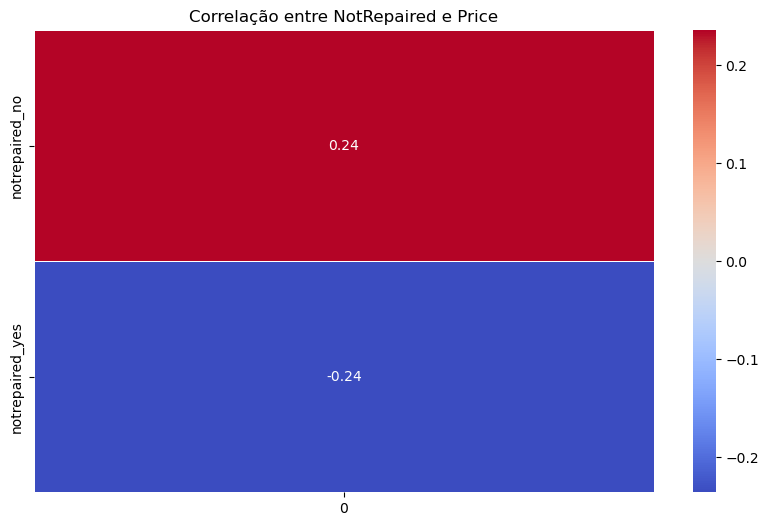

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlação entre NotRepaired e Price')
plt.show()

### Fueltype 

In [26]:
df_encoded.isna().sum()

price                         0
registrationyear              0
power                         0
mileage                       0
fueltype                   8513
brand                         0
model                      7910
vehicletype_bus               0
vehicletype_convertible       0
vehicletype_coupe             0
vehicletype_other             0
vehicletype_sedan             0
vehicletype_small             0
vehicletype_suv               0
vehicletype_wagon             0
gearbox_auto                  0
gearbox_manual                0
notrepaired_no                0
notrepaired_yes               0
dtype: int64

In [27]:
df_encoded = df_encoded.dropna(subset=['fueltype'])

In [28]:
temp_encoded_z = pd.get_dummies(df_encoded['fueltype'], prefix='fueltype')
df_encoded['fueltype_cng'] = temp_encoded_z['fueltype_cng']
df_encoded['fueltype_electric'] = temp_encoded_z['fueltype_electric']
df_encoded['fueltype_gasoline'] = temp_encoded_z['fueltype_gasoline']
df_encoded['fueltype_hybrid'] = temp_encoded_z['fueltype_hybrid']
df_encoded['fueltype_lpg'] = temp_encoded_z['fueltype_lpg']
df_encoded['fueltype_other'] = temp_encoded_z['fueltype_other']
df_encoded['fueltype_petrol'] = temp_encoded_z['fueltype_petrol']


correlation_matrix = df_encoded.filter(like='fueltype_').corrwith(df_encoded['price'])

print(correlation_matrix)

fueltype_cng        -0.002860
fueltype_electric    0.007895
fueltype_gasoline    0.282896
fueltype_hybrid      0.031366
fueltype_lpg        -0.021397
fueltype_other      -0.008535
fueltype_petrol     -0.274354
dtype: float64


In [29]:
df_encoded.drop(columns='fueltype', inplace=True)

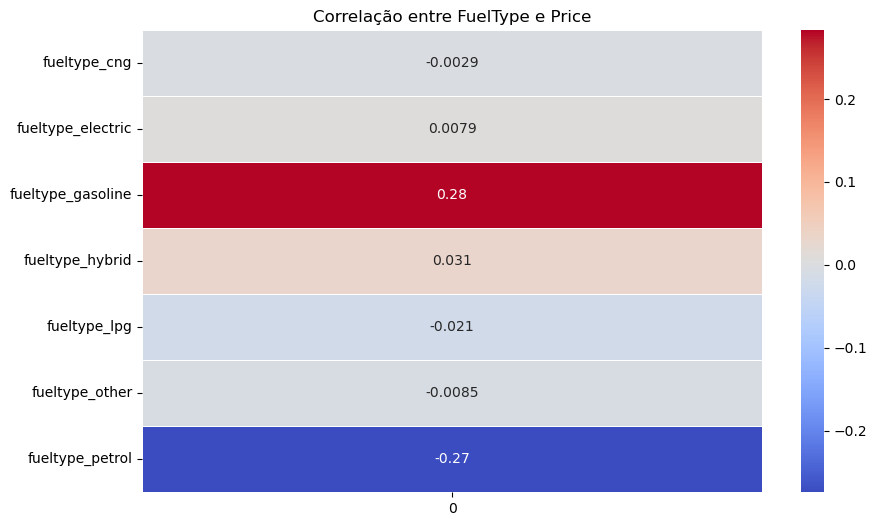

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlação entre FuelType e Price')
plt.show()

### Brand

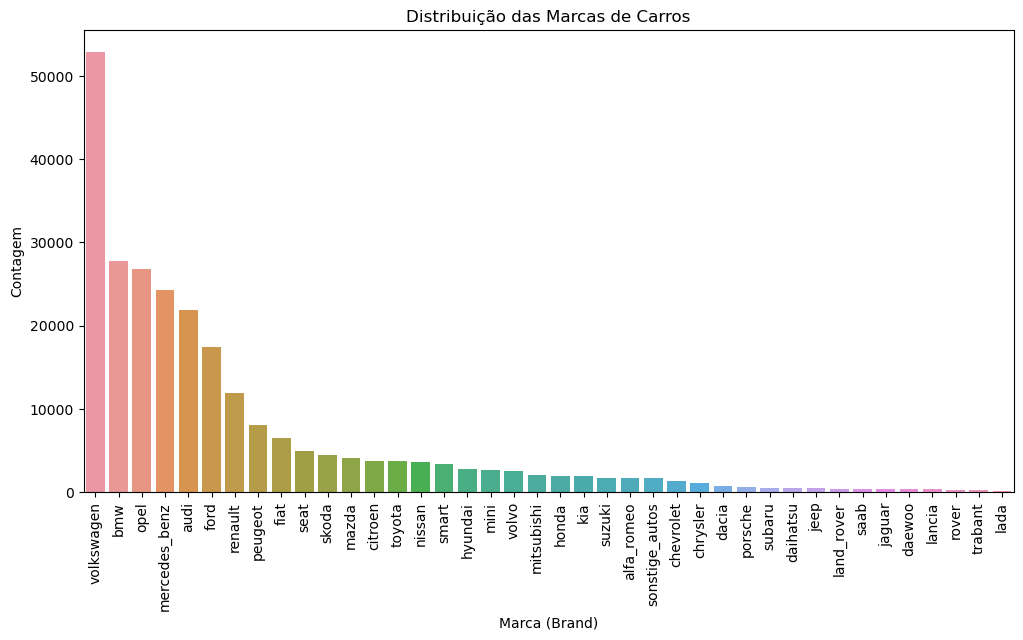

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_encoded, x='brand', order=df_encoded['brand'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Marca (Brand)')
plt.ylabel('Contagem')
plt.title('Distribuição das Marcas de Carros')
plt.show()

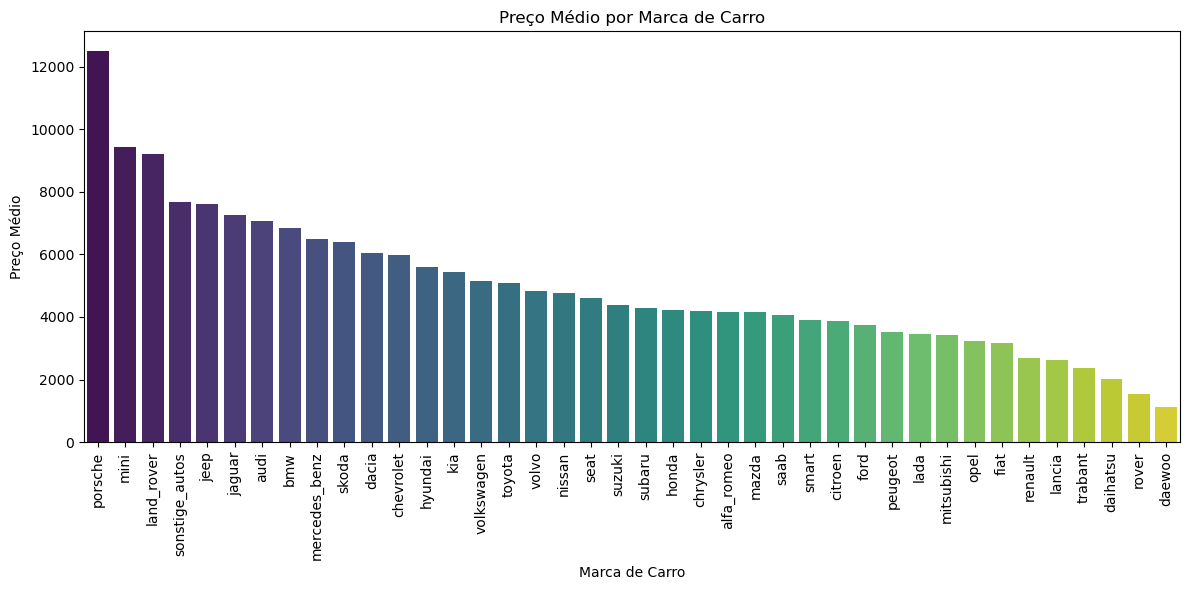

In [32]:
brand_avg_price = df_encoded.groupby('brand')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Marca de Carro')
plt.ylabel('Preço Médio')
plt.title('Preço Médio por Marca de Carro')
plt.tight_layout()

# Mostrando o gráfico
plt.show()

### Model

In [33]:
df_encoded.isna().sum()

price                         0
registrationyear              0
power                         0
mileage                       0
brand                         0
model                      6501
vehicletype_bus               0
vehicletype_convertible       0
vehicletype_coupe             0
vehicletype_other             0
vehicletype_sedan             0
vehicletype_small             0
vehicletype_suv               0
vehicletype_wagon             0
gearbox_auto                  0
gearbox_manual                0
notrepaired_no                0
notrepaired_yes               0
fueltype_cng                  0
fueltype_electric             0
fueltype_gasoline             0
fueltype_hybrid               0
fueltype_lpg                  0
fueltype_other                0
fueltype_petrol               0
dtype: int64

In [34]:
df_encoded = df_encoded.dropna(subset=['model'])

In [35]:
df_encoded['model'].value_counts()

model
golf                  20200
other                 18480
3er                   14894
polo                   8806
corsa                  8265
                      ...  
i3                        4
samara                    3
serie_3                   3
range_rover_evoque        2
rangerover                2
Name: count, Length: 249, dtype: int64

In [36]:
model_names_unique = df_encoded['model'].unique()

print(model_names_unique)

['golf' 'fabia' '3er' '2_reihe' 'other' '3_reihe' 'passat' 'navara'
 'twingo' 'c_max' 'a_klasse' 'scirocco' '5er' 'arosa' 'civic'
 'transporter' 'punto' 'e_klasse' 'one' 'clio' '1er' 'b_klasse' 'astra'
 'fortwo' 'a8' 'jetta' 'polo' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' '156' 'escort' 'forester' 'scenic' 'a1' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'slk' '7er' '80' '147' 'meriva' 'z_reihe' 'v40' 'ibiza'
 'mustang' 'eos' 'a4' 'touran' 'getz' 'insignia' 'megane' 'a3' 'lupo'
 'r19' 'colt' 'corsa' 'vectra' 'berlingo' 'tiguan' 'sharan' '6_reihe' 'c4'
 'panda' 'up' 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia'
 'zafira' 'mii' 'rx_reihe' 'mondeo' '6er' 'fox' 'matiz' 'beetle' 'rio'
 'touareg' 'logan' 'omega' 'cuore' 's_max' 'modus' 'a2' 'galaxy' 'c3'
 'viano' 's_klasse' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper'
 'leon' 'sportage' 'caddy' 'clk' 'primera' '4_reihe' 'espace' 'exeo'
 'juke' 'x_reihe' '1_reihe' 'accord' 'corolla' 'grand' 'phaeton' 'cordoba'
 'verso' 'swift' 'rav'

In [37]:
model_names_unique_sorted = sorted(model_names_unique)

for model_name in model_names_unique_sorted:
    print(model_name)

100
145
147
156
159
1_reihe
1er
200
2_reihe
300c
3_reihe
3er
4_reihe
500
5_reihe
5er
601
6_reihe
6er
7er
80
850
90
900
9000
911
a1
a2
a3
a4
a5
a6
a8
a_klasse
accord
agila
alhambra
almera
altea
amarok
antara
arosa
astra
auris
avensis
aveo
aygo
b_klasse
b_max
beetle
berlingo
bora
boxster
bravo
c1
c2
c3
c4
c5
c_klasse
c_max
c_reihe
caddy
calibra
captiva
carisma
carnival
cayenne
cc
ceed
charade
cherokee
citigo
civic
cl
clio
clk
clubman
colt
combo
cooper
cordoba
corolla
corsa
cr_reihe
croma
crossfire
cuore
cx_reihe
defender
delta
discovery
doblo
ducato
duster
e_klasse
elefantino
eos
escort
espace
exeo
fabia
fiesta
focus
forester
forfour
fortwo
fox
freelander
fusion
g_klasse
galant
galaxy
getz
gl
glk
golf
grand
i3
i_reihe
ibiza
impreza
insignia
jazz
jetta
jimny
juke
justy
ka
kadett
kaefer
kalina
kalos
kangoo
kappa
kuga
laguna
lancer
lanos
legacy
leon
lodgy
logan
lupo
lybra
m_klasse
m_reihe
materia
matiz
megane
meriva
micra
mii
modus
mondeo
move
musa
mustang
mx_reihe
navara
niva
note
nubira
o

**Conclusões intermediárias:** Nesta etapa, eu limpei o dataset removendo os valores nulos e utilizei o método one-hot encoding nas colunas VehicleType, GearBox, NotRepaired e FuelType. As colunas Brand e Model serão codificadas através do método de alta escalabilidade Probability Encoding. Também observamos a correlação de cada coluna (que foi mantida no df) com o preço do carro.

## Divisão entre treino e teste

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded, df_encoded['price'], test_size=0.3, random_state=42)

# Calculando as probabilidades de ocorrência da classe alvo (Price) para cada categoria na coluna 'Model' apenas nos dados de treinamento.
model_probabilities = X_train.groupby('model')['price'].mean().reset_index()
model_probabilities.rename(columns={'price': 'Model_Probability'}, inplace=True)

# Realizando a junção dos dados de treinamento e teste com as probabilidades de 'Model'.
X_train = pd.merge(X_train, model_probabilities, on='model', how='left')
X_test = pd.merge(X_test, model_probabilities, on='model', how='left')

# Calculndo as probabilidades de ocorrência da classe alvo (Price) para cada categoria na coluna 'Brand' apenas nos dados de treinamento.
brand_probabilities = X_train.groupby('brand')['price'].mean().reset_index()
brand_probabilities.rename(columns={'price': 'Brand_Probability'}, inplace=True)

# Realizando a junção dos dados de treinamento e teste com as probabilidades de 'Brand'.
X_train = pd.merge(X_train, brand_probabilities, on='brand', how='left')
X_test = pd.merge(X_test, brand_probabilities, on='brand', how='left')

# Removendo as colunas 'model' e 'brand' dos conjuntos de treinamento e teste.
X_train.drop(columns=['model', 'brand', 'price'], inplace=True)
X_test.drop(columns=['model', 'brand', 'price'], inplace=True)

Aqui eu dividi os dados entre treino e teste e apliquei o método de alta escalabilidade Probability Encoding nas colunas model e brand

## Treinamento do modelo

### CATBOOSTREGRESSOR + OPTUNA

In [39]:
def objective(trial):
    
    param = {
        'iterations': trial.suggest_categorical('iterations', [1000, 1500, 2000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 5.0),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'verbose': False,
    }

    model = CatBoostRegressor(**param)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)  # Passar squared=False retorna o RMSE diretamente

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  

best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"RMSE: {rmse}")

[I 2024-02-06 15:46:09,559] A new study created in memory with name: no-name-21ad414a-c9aa-4a26-a1dd-ac44b0f8b057
[I 2024-02-06 15:46:35,758] Trial 0 finished with value: 1576.5318529917374 and parameters: {'iterations': 2000, 'learning_rate': 0.08290086449949127, 'depth': 7, 'l2_leaf_reg': 3.5308562535417285}. Best is trial 0 with value: 1576.5318529917374.
[I 2024-02-06 15:46:55,396] Trial 1 finished with value: 1582.0075022022502 and parameters: {'iterations': 1000, 'learning_rate': 0.065350138296209, 'depth': 9, 'l2_leaf_reg': 4.099692305762845}. Best is trial 0 with value: 1576.5318529917374.
[I 2024-02-06 15:47:22,831] Trial 2 finished with value: 1579.5710440229377 and parameters: {'iterations': 1000, 'learning_rate': 0.04730993414329287, 'depth': 10, 'l2_leaf_reg': 3.6597810005875058}. Best is trial 0 with value: 1576.5318529917374.
[I 2024-02-06 15:47:46,310] Trial 3 finished with value: 1589.9956952256512 and parameters: {'iterations': 1500, 'learning_rate': 0.043872713274647

Melhores hiperparâmetros: {'iterations': 1500, 'learning_rate': 0.05699599103832775, 'depth': 9, 'l2_leaf_reg': 1.29248194631881}
0:	learn: 4516.4095166	total: 23.5ms	remaining: 35.2s
1:	learn: 4331.1943936	total: 45.2ms	remaining: 33.9s
2:	learn: 4160.3346654	total: 67.9ms	remaining: 33.9s
3:	learn: 3998.8756007	total: 88.4ms	remaining: 33.1s
4:	learn: 3847.2543410	total: 109ms	remaining: 32.6s
5:	learn: 3707.1967128	total: 130ms	remaining: 32.3s
6:	learn: 3576.9786085	total: 149ms	remaining: 31.8s
7:	learn: 3456.7350445	total: 166ms	remaining: 30.9s
8:	learn: 3343.4772468	total: 190ms	remaining: 31.4s
9:	learn: 3237.3649685	total: 210ms	remaining: 31.3s
10:	learn: 3140.2868580	total: 231ms	remaining: 31.3s
11:	learn: 3046.5607241	total: 252ms	remaining: 31.2s
12:	learn: 2960.9864717	total: 271ms	remaining: 31s
13:	learn: 2881.9992573	total: 291ms	remaining: 30.9s
14:	learn: 2808.8325811	total: 310ms	remaining: 30.7s
15:	learn: 2738.8511586	total: 331ms	remaining: 30.7s
16:	learn: 267

In [40]:
mae = mean_absolute_error(y_test, y_pred)
mae

976.0816305555346

Módelo CatBoostRegressor: RMSE 1561, mae 974

### LightGBM + Optuna

In [41]:
%%time

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lgbm_params = {
    'objective': 'regression',  
    'metric': 'rmse',           
    'boosting_type': 'gbdt',    
    'num_leaves': 31,           
    'learning_rate': 0.04,     
    'feature_fraction': 1,   
    'bagging_fraction': 0.8,   
    'bagging_freq': 5,         
    'verbose': 1,               
    'n_estimators':450,
    'num_leaves':600
}

lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=100, valid_sets=[test_data])

y_pred = lgbm_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359
CPU times: total: 1min 3s
Wall time: 14.4 s


In [42]:
def objective(trial):
    
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'random_state': 42
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    model = lgb.train(param, train_data, valid_sets=[test_data])

    preds = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  

best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

train_data = lgb.Dataset(X_train, label=y_train)
best_lgbm_model = lgb.train(best_params, train_data)

y_pred = best_lgbm_model.predict(X_test, num_iteration=best_lgbm_model.best_iteration)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

[I 2024-02-06 15:51:18,562] A new study created in memory with name: no-name-67462b5c-f946-4add-9775-0775961c87df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:21,320] Trial 0 finished with value: 1626.7937552320502 and parameters: {'num_leaves': 81, 'learning_rate': 0.036244176782717755, 'feature_fraction': 0.9667181244490207, 'bagging_fraction': 0.8099639872495914, 'bagging_freq': 5, 'n_estimators': 220}. Best is trial 0 with value: 1626.7937552320502.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:24,238] Trial 1 finished with value: 1815.113844118466 and parameters: {'num_leaves': 52, 'learning_rate': 0.010224074916218847, 'feature_fraction': 0.9328507931641415, 'bagging_fraction': 0.7931137368971913, 'bagging_freq': 10, 'n_estimators': 287}. Best is trial 0 with value: 1626.7937552320502.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:26,083] Trial 2 finished with value: 2021.3016979760753 and parameters: {'num_leaves': 95, 'learning_rate': 0.014990106210348023, 'feature_fraction': 0.9135945600613923, 'bagging_fraction': 0.8329725261748397, 'bagging_freq': 5, 'n_estimators': 115}. Best is trial 0 with value: 1626.7937552320502.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:27,986] Trial 3 finished with value: 1591.6621131602744 and parameters: {'num_leaves': 88, 'learning_rate': 0.08903898025325635, 'feature_fraction': 0.8834626035943319, 'bagging_fraction': 0.8502339754791304, 'bagging_freq': 6, 'n_estimators': 173}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:29,691] Trial 4 finished with value: 1724.233103260519 and parameters: {'num_leaves': 39, 'learning_rate': 0.026425448790829663, 'feature_fraction': 0.858964534564489, 'bagging_fraction': 0.8990673356619039, 'bagging_freq': 9, 'n_estimators': 196}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:31,374] Trial 5 finished with value: 1625.8503583644742 and parameters: {'num_leaves': 40, 'learning_rate': 0.07224765589271617, 'feature_fraction': 0.8520548638872235, 'bagging_fraction': 0.8976337271648269, 'bagging_freq': 8, 'n_estimators': 239}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:33,392] Trial 6 finished with value: 1604.9643462593976 and parameters: {'num_leaves': 59, 'learning_rate': 0.06514445370471521, 'feature_fraction': 0.9389118067429533, 'bagging_fraction': 0.716134188038985, 'bagging_freq': 9, 'n_estimators': 273}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:35,729] Trial 7 finished with value: 1766.4879041761085 and parameters: {'num_leaves': 81, 'learning_rate': 0.014767274850662315, 'feature_fraction': 0.945221133374843, 'bagging_fraction': 0.8350237525142505, 'bagging_freq': 8, 'n_estimators': 202}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:38,256] Trial 8 finished with value: 1596.559580760684 and parameters: {'num_leaves': 82, 'learning_rate': 0.050516525970596186, 'feature_fraction': 0.9028463245280642, 'bagging_fraction': 0.7102663431542207, 'bagging_freq': 8, 'n_estimators': 288}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:39,893] Trial 9 finished with value: 1695.0251884917604 and parameters: {'num_leaves': 40, 'learning_rate': 0.03354264255158592, 'feature_fraction': 0.907614022745571, 'bagging_fraction': 0.8959666955650853, 'bagging_freq': 5, 'n_estimators': 189}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:41,378] Trial 10 finished with value: 1597.7919781739563 and parameters: {'num_leaves': 99, 'learning_rate': 0.09337614858571741, 'feature_fraction': 0.8095150282994441, 'bagging_fraction': 0.7709503735596112, 'bagging_freq': 6, 'n_estimators': 134}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:43,295] Trial 11 finished with value: 1602.725940054748 and parameters: {'num_leaves': 78, 'learning_rate': 0.098958669489571, 'feature_fraction': 0.868793704776392, 'bagging_fraction': 0.7023576998004578, 'bagging_freq': 7, 'n_estimators': 156}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:44,892] Trial 12 finished with value: 1635.724347063255 and parameters: {'num_leaves': 71, 'learning_rate': 0.04831568699290631, 'feature_fraction': 0.8831046995475031, 'bagging_fraction': 0.7466980669738769, 'bagging_freq': 7, 'n_estimators': 162}. Best is trial 3 with value: 1591.6621131602744.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:47,183] Trial 13 finished with value: 1578.509960012932 and parameters: {'num_leaves': 91, 'learning_rate': 0.08031346700368719, 'feature_fraction': 0.9880500947901768, 'bagging_fraction': 0.8571887458276983, 'bagging_freq': 6, 'n_estimators': 250}. Best is trial 13 with value: 1578.509960012932.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:49,486] Trial 14 finished with value: 1576.3219893939483 and parameters: {'num_leaves': 92, 'learning_rate': 0.08439168860091907, 'feature_fraction': 0.9909357392807497, 'bagging_fraction': 0.858235645442672, 'bagging_freq': 6, 'n_estimators': 248}. Best is trial 14 with value: 1576.3219893939483.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:51,691] Trial 15 finished with value: 1575.5004870200228 and parameters: {'num_leaves': 92, 'learning_rate': 0.07855020491675509, 'feature_fraction': 0.9968106662184231, 'bagging_fraction': 0.8626860408319916, 'bagging_freq': 6, 'n_estimators': 249}. Best is trial 15 with value: 1575.5004870200228.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:53,756] Trial 16 finished with value: 1590.4843711062567 and parameters: {'num_leaves': 66, 'learning_rate': 0.07998011113909864, 'feature_fraction': 0.9949171143566429, 'bagging_fraction': 0.8686509437782725, 'bagging_freq': 6, 'n_estimators': 255}. Best is trial 15 with value: 1575.5004870200228.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:55,772] Trial 17 finished with value: 1597.7068297763356 and parameters: {'num_leaves': 72, 'learning_rate': 0.06361069147206458, 'feature_fraction': 0.9729517384020179, 'bagging_fraction': 0.8739289322823814, 'bagging_freq': 7, 'n_estimators': 230}. Best is trial 15 with value: 1575.5004870200228.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:51:58,529] Trial 18 finished with value: 1570.7964709586845 and parameters: {'num_leaves': 100, 'learning_rate': 0.08317352132449737, 'feature_fraction': 0.9650769847536367, 'bagging_fraction': 0.8194429536230514, 'bagging_freq': 6, 'n_estimators': 267}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:01,323] Trial 19 finished with value: 1573.9879752209993 and parameters: {'num_leaves': 100, 'learning_rate': 0.0714686531141618, 'feature_fraction': 0.9607343546817882, 'bagging_fraction': 0.8082677781597265, 'bagging_freq': 5, 'n_estimators': 276}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:03,916] Trial 20 finished with value: 1583.07540752159 and parameters: {'num_leaves': 100, 'learning_rate': 0.05882662448539855, 'feature_fraction': 0.9624979876875672, 'bagging_fraction': 0.8004389331849012, 'bagging_freq': 5, 'n_estimators': 270}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:06,363] Trial 21 finished with value: 1579.0116206541911 and parameters: {'num_leaves': 89, 'learning_rate': 0.07254050530926796, 'feature_fraction': 0.9521252041607992, 'bagging_fraction': 0.8206002112636259, 'bagging_freq': 5, 'n_estimators': 269}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:08,948] Trial 22 finished with value: 1576.448727032756 and parameters: {'num_leaves': 100, 'learning_rate': 0.07346674676895695, 'feature_fraction': 0.975784385193717, 'bagging_fraction': 0.7806408808131606, 'bagging_freq': 6, 'n_estimators': 295}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:10,855] Trial 23 finished with value: 1586.403416213084 and parameters: {'num_leaves': 86, 'learning_rate': 0.08896656737195878, 'feature_fraction': 0.9310816370361561, 'bagging_fraction': 0.7557023346279813, 'bagging_freq': 7, 'n_estimators': 213}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:13,214] Trial 24 finished with value: 1575.2244394072327 and parameters: {'num_leaves': 95, 'learning_rate': 0.07745603324703193, 'feature_fraction': 0.9815619300552237, 'bagging_fraction': 0.8322718975450665, 'bagging_freq': 5, 'n_estimators': 262}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:16,894] Trial 25 finished with value: 1580.446732295151 and parameters: {'num_leaves': 97, 'learning_rate': 0.06387067505239263, 'feature_fraction': 0.9571660482543478, 'bagging_fraction': 0.8233814314759217, 'bagging_freq': 5, 'n_estimators': 299}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:18,767] Trial 26 finished with value: 1592.3766595138025 and parameters: {'num_leaves': 52, 'learning_rate': 0.09817879896427512, 'feature_fraction': 0.9189421618574415, 'bagging_fraction': 0.8371095375219638, 'bagging_freq': 5, 'n_estimators': 267}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:20,596] Trial 27 finished with value: 1648.544346055221 and parameters: {'num_leaves': 31, 'learning_rate': 0.05604814180265621, 'feature_fraction': 0.9786879073422601, 'bagging_fraction': 0.8083483664521127, 'bagging_freq': 5, 'n_estimators': 279}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:22,741] Trial 28 finished with value: 1586.611401931024 and parameters: {'num_leaves': 95, 'learning_rate': 0.06798921602855677, 'feature_fraction': 0.9251870562992596, 'bagging_fraction': 0.7883559742641358, 'bagging_freq': 6, 'n_estimators': 226}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:24,681] Trial 29 finished with value: 1582.9720271932472 and parameters: {'num_leaves': 85, 'learning_rate': 0.08555128133393425, 'feature_fraction': 0.967545079870414, 'bagging_fraction': 0.8165038173818113, 'bagging_freq': 5, 'n_estimators': 212}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:27,055] Trial 30 finished with value: 1608.690156854369 and parameters: {'num_leaves': 74, 'learning_rate': 0.046957389105690035, 'feature_fraction': 0.9484332813830306, 'bagging_fraction': 0.806143974915216, 'bagging_freq': 5, 'n_estimators': 257}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:29,237] Trial 31 finished with value: 1577.469483025737 and parameters: {'num_leaves': 93, 'learning_rate': 0.08017763088597754, 'feature_fraction': 0.9998488764012019, 'bagging_fraction': 0.8426593573465528, 'bagging_freq': 6, 'n_estimators': 243}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:32,095] Trial 32 finished with value: 1574.9974496559375 and parameters: {'num_leaves': 95, 'learning_rate': 0.07747077780627427, 'feature_fraction': 0.9798776739957704, 'bagging_fraction': 0.8705061377941562, 'bagging_freq': 6, 'n_estimators': 263}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:34,677] Trial 33 finished with value: 1574.399669129712 and parameters: {'num_leaves': 96, 'learning_rate': 0.07454648717099194, 'feature_fraction': 0.976663370076215, 'bagging_fraction': 0.8257431909184519, 'bagging_freq': 5, 'n_estimators': 280}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:37,232] Trial 34 finished with value: 1578.7555013515985 and parameters: {'num_leaves': 86, 'learning_rate': 0.07032014990102535, 'feature_fraction': 0.9625092184343879, 'bagging_fraction': 0.8818344297301957, 'bagging_freq': 7, 'n_estimators': 286}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:39,689] Trial 35 finished with value: 1570.979994821913 and parameters: {'num_leaves': 97, 'learning_rate': 0.09334931436623792, 'feature_fraction': 0.9420391497934648, 'bagging_fraction': 0.7946298359753515, 'bagging_freq': 5, 'n_estimators': 282}. Best is trial 18 with value: 1570.7964709586845.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:42,072] Trial 36 finished with value: 1569.4374399774397 and parameters: {'num_leaves': 98, 'learning_rate': 0.09218805691816312, 'feature_fraction': 0.9379316876274175, 'bagging_fraction': 0.7906643144417209, 'bagging_freq': 10, 'n_estimators': 282}. Best is trial 36 with value: 1569.4374399774397.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:44,735] Trial 37 finished with value: 1568.987059633165 and parameters: {'num_leaves': 100, 'learning_rate': 0.09409464583923735, 'feature_fraction': 0.9368000081634115, 'bagging_fraction': 0.7681139096930546, 'bagging_freq': 10, 'n_estimators': 300}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:47,690] Trial 38 finished with value: 1574.0538105979463 and parameters: {'num_leaves': 89, 'learning_rate': 0.0935390652242288, 'feature_fraction': 0.9396619109167635, 'bagging_fraction': 0.7639185233008587, 'bagging_freq': 10, 'n_estimators': 298}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:50,054] Trial 39 finished with value: 1580.1790076205825 and parameters: {'num_leaves': 81, 'learning_rate': 0.0936728123198619, 'feature_fraction': 0.8869339742274783, 'bagging_fraction': 0.735755840506241, 'bagging_freq': 10, 'n_estimators': 284}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:52,090] Trial 40 finished with value: 1592.410455375688 and parameters: {'num_leaves': 58, 'learning_rate': 0.0881985175496474, 'feature_fraction': 0.9151383494139634, 'bagging_fraction': 0.7927371339343704, 'bagging_freq': 9, 'n_estimators': 289}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:54,598] Trial 41 finished with value: 1570.5154201312073 and parameters: {'num_leaves': 100, 'learning_rate': 0.09505703965479521, 'feature_fraction': 0.9334606155722402, 'bagging_fraction': 0.7782190333316972, 'bagging_freq': 9, 'n_estimators': 275}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:57,271] Trial 42 finished with value: 1569.3968098054904 and parameters: {'num_leaves': 97, 'learning_rate': 0.0949816039801432, 'feature_fraction': 0.9328315168464638, 'bagging_fraction': 0.7794592944078523, 'bagging_freq': 9, 'n_estimators': 299}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:52:59,866] Trial 43 finished with value: 1571.615386948041 and parameters: {'num_leaves': 100, 'learning_rate': 0.09742504306986803, 'feature_fraction': 0.928978597955769, 'bagging_fraction': 0.7792462712349604, 'bagging_freq': 9, 'n_estimators': 298}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:53:02,221] Trial 44 finished with value: 1580.3436446825422 and parameters: {'num_leaves': 89, 'learning_rate': 0.0848720068531918, 'feature_fraction': 0.8935441683106617, 'bagging_fraction': 0.7707468137226725, 'bagging_freq': 10, 'n_estimators': 234}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:53:03,665] Trial 45 finished with value: 1612.877200563904 and parameters: {'num_leaves': 93, 'learning_rate': 0.09108995749658275, 'feature_fraction': 0.9224278049891821, 'bagging_fraction': 0.7377524940828313, 'bagging_freq': 10, 'n_estimators': 104}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:53:06,976] Trial 46 finished with value: 1569.1863166314058 and parameters: {'num_leaves': 97, 'learning_rate': 0.0999989835983814, 'feature_fraction': 0.9089132411145124, 'bagging_fraction': 0.7591774291288858, 'bagging_freq': 9, 'n_estimators': 290}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:53:10,484] Trial 47 finished with value: 1576.070358259814 and parameters: {'num_leaves': 84, 'learning_rate': 0.0992332716619668, 'feature_fraction': 0.9054873624603181, 'bagging_fraction': 0.7550747980860485, 'bagging_freq': 9, 'n_estimators': 292}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:53:12,692] Trial 48 finished with value: 1576.8119344478744 and parameters: {'num_leaves': 77, 'learning_rate': 0.09599673100778434, 'feature_fraction': 0.9124632295806586, 'bagging_fraction': 0.7834749521381149, 'bagging_freq': 8, 'n_estimators': 290}. Best is trial 37 with value: 1568.987059633165.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359


[I 2024-02-06 15:53:15,288] Trial 49 finished with value: 1574.4121066019402 and parameters: {'num_leaves': 91, 'learning_rate': 0.08979393870378533, 'feature_fraction': 0.9348461578280891, 'bagging_fraction': 0.7251013984695647, 'bagging_freq': 9, 'n_estimators': 300}. Best is trial 37 with value: 1568.987059633165.


Melhores hiperparâmetros: {'num_leaves': 100, 'learning_rate': 0.09409464583923735, 'feature_fraction': 0.9368000081634115, 'bagging_fraction': 0.7681139096930546, 'bagging_freq': 10, 'n_estimators': 300}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 172069, number of used features: 24
[LightGBM] [Info] Start training from score 5122.569359
RMSE: 1569.5857148373807


In [43]:
mae = mean_absolute_error(y_test, y_pred)
mae

979.2271744731866

Módelo LGBM: RMSE 1549, mae 960

### RandomForest + optuna

In [44]:
%%time

random_forest_params = {
    'n_estimators': 100,      
    'max_depth': None,       
    'min_samples_split': 2,  
    'min_samples_leaf': 1,   
    'max_features': 'sqrt',  
    'random_state': 42       
}

random_forest_model = RandomForestRegressor(**random_forest_params)  

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1591.3342097960453
CPU times: total: 20.7 s
Wall time: 20.7 s


In [45]:
def objective(trial):
    
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
    max_features = trial.suggest_categorical('max_features', ['sqrt'])
    random_state = 42  

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=random_state
    )

    X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    model.fit(X_train_, y_train_)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Ajuste o n_trials conforme necessário

best_params = study.best_params
print("Melhores hiperparâmetros:", best_params)

best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

[I 2024-02-06 15:53:38,571] A new study created in memory with name: no-name-d887040e-c522-4570-a4c9-1233b4791986
[I 2024-02-06 15:53:44,203] Trial 0 finished with value: 3945232.5158222415 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 3945232.5158222415.
[I 2024-02-06 15:54:21,362] Trial 1 finished with value: 2635569.5804602033 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 2635569.5804602033.
[I 2024-02-06 15:54:50,475] Trial 2 finished with value: 2829077.5691798734 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 2635569.5804602033.
[I 2024-02-06 15:55:01,248] Trial 3 finished with value: 2587397.3968612845 and parameters: {'n_estimators': 100, 'max_depth': 2

Melhores hiperparâmetros: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
RMSE: 1574.0021034606377


In [46]:
mae = mean_absolute_error(y_test, y_pred)
mae

986.3187752671149

Módelo RandomForest: RMSE 1617, mae 988

### LinearRegression

In [47]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [48]:
model_lr = LinearRegression()

model_lr.fit(X_train_scaled, y_train)

y_pred = model_lr.predict(X_test_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')

RMSE: 2904.821344676087
R²: 0.6229444835016992


**Conclusões**

O conjunto de dados era robusto, o que ajudou na predição dos modelos de ML. No entanto, apresentava diversos valores ausentes e algumas colunas possuíam valores inadequados para certos tipos de algoritmos de ML. Além disso, havia a presença de colunas que não contribuiriam significativamente para a previsão dos modelos. Claro, essas colunas, apesar de não serem importantes para a previsão, podem ser dados potencialmente relevantes para análises mais aprofundadas, o que torna esses dados valiosos de qualquer maneira.

No pré-processamento de dados, optei por remover algumas colunas que considerei irrelevantes para os modelos. Também removi os valores ausentes nas colunas que mantive e calculei a correlação de cada coluna com o preço do carro. Utilizei o método de codificação one-hot nas colunas "vehicletype," "gearbox," "notrepaired," e "fueltype." Para as colunas "brand" e "model," apliquei o método de alta escalabilidade Probability Encoding após dividir os dados em treino e teste para evitar vazamento de dados.

Performance dos modelos:

CatBoostRegressor: O modelo com os hiperparâmetros escolhidos levou aproximadamente 3 minutos para treinar. O RMSE foi de 1561, e o MAE foi 974.

LightGBM: O modelo com os hiperparâmetros escolhidos levou aproximadamente 1 minuto e 20 segundos para treinar. O RMSE foi de 1549, e o MAE foi 960.

RandomForestRegressor: O modelo com os hiperparâmetros escolhidos levou aproximadamente 1 minuto e 20 segundos para treinar. O RMSE foi de 1617, e o MAE foi 988.

LinearRegression: Este modelo foi escolhido como referência para comparar com os outros modelos mais avançados de regressão. O RMSE foi de 2904, e o R2 foi de 0.6229.

Nota: O RMSE (Root Mean Squared Error) é uma medida que usamos para avaliar a precisão de um modelo de previsão. Em termos simples, é como se fosse um "número que indica o quão bem nosso modelo acerta." Quanto menor o RMSE, melhor, porque isso significa que nosso modelo faz previsões mais próximas da realidade. É uma forma de medir o quão bem nosso modelo está funcionando. Quanto mais próximo de zero o RMSE, mais confiável é o modelo.

MAE (Mean Absolute Error) é uma medida que nos diz o tamanho médio dos erros de previsão, em média. Em outras palavras, o MAE mostra o quão erradas, em média, são as previsões de um modelo, independentemente de os erros serem positivos ou negativos. Quanto menor o valor do MAE, mais preciso é o modelo, pois isso significa que suas previsões estão, em média, mais próximas dos valores reais.